# How to build a NLP sentiment classifier for Movie Reviews

First I need to give credit to the real author [@davisdavid](https://linkedin.com/in/davis-david-783461124) who's post on Hackernoon inspired this lab example.

__About Davis:__
Davis David is a Tanzania based Data scientist with a background in Computer Science. He is the Co-Organizer and Facilitator of Artificial Intelligence (AI) movement in Tanzania by conducting AI meetups, workshops and events with a passion to build a community of Data Scientists in Tanzania to solve our local problems. Also, he organized Pythontz and TanzanAi Lab Community and became Ambassador of ZindiAfrica in Tanzania.

### About the Notebook

This jupyter notebooks uses the IMBD Movie Review dataset to build a machine learning pipeline for sentiment classification of movie reviews. Running this script will produce a scikit learn pipeline with an classification estimator that can be deployed as a real time inference web service 

### About the Dataset

The __IMDb Movie Reviews__ dataset is a binary sentiment analysis dataset consisting of 50,000 reviews from the Internet Movie Database (IMDb) labeled as positive or negative. The dataset contains an even number of positive and negative reviews. Only highly polarizing reviews are considered. A negative review has a score ≤ 4 out of 10, and a positive review has a score ≥ 7 out of 10. No more than 30 reviews are included per movie. The dataset contains additional unlabeled data.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from string import punctuation 
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import re 

# Download dependency for nltk
for dependency in (
    "stopwords",
    "brown",
    "names",
    "wordnet",
    "averaged_perceptron_tagger",
    "universal_tagset",
):
    nltk.download(dependency)
    
import warnings
warnings.filterwarnings("ignore")

# seeding
np.random.seed(32)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\iluor\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\iluor\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package names to
[nltk_data]     C:\Users\iluor\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\iluor\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\iluor\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\iluor\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\universal_tagset.zip.


### Exploratory Data Analysis


In [11]:
# load data to a pandas dataframe
data = pd.read_csv("..\data\labeledTrainData.csv", encoding='latin1')

In [12]:
# show top five rows of data
data.head(10) 


,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...
5,8196_8,1,I dont know why people think this is such a ba...
6,7166_2,0,"This movie could have been very good, but come..."
7,10633_1,0,I watched this video at a friend's house. I'm ...
8,319_1,0,"A friend of mine bought this film for £1, and ..."
9,8713_10,1,<br /><br />This movie is full of references. ...


In [13]:
# check the shape of the data
data.shape

(25000, 3)

In [14]:
# check missing values in data
data.isnull().sum()

id           0
sentiment    0
review       0
dtype: int64

In [15]:
# evalute news sentiment distribution
data.sentiment.value_counts()

1    12500
0    12500
Name: sentiment, dtype: int64

### Data Preprocessing

__What are Stop Words__ - are commonly used words that are excluded from searches because it has low discriminating power or results in unwanted behavior in your results. They can safely be ignored without sacrificing the meaning of the sentence. For sentiment analysis, we need to remove stop words as they do not provide any information to our model. 
What are Word Stems. 

__What are word stems and stemming?__ - a stem is part of a word responsible for its lexical meaning. Stemming is an NLP process that reduces the inflection in wordss to their root forms, which helps us process and normalize text. 
example: Lets look at the root and stems for the word _connect_:

    - connects -> connect
    - connecting -> connect
    - connection -> connect

__What is lemmatization__ - is the process of grouping together the different inflected forms of a word so they can be analyzed as a single item. Lemmatization is similar to stemming but it brings context to the words to link words with similar meanings.
examples of lemmatization:

    - rocks -> rock
    - better -> good
    - corpora -> corpus

In [17]:
# gets the english corpus of stop words
stop_words =  stopwords.words('english')
#print(stop_words) # uncomment this line if you want to see the list of stop words

def text_cleaning(text, remove_stop_words=True, lemmatize_words=True):
    # Clean the text, with the option to remove stop_words and to lemmatize word

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9]", " ", text) # include only alpha-numeric characters
    text = re.sub(r"\'s", " ", text) # clean white space
    text =  re.sub(r'http\S+',' link ', text) # clean any web links that may be in the reviews
    text = re.sub(r'\b\d+(?:\.\d+)?\s+', '', text) # remove numbers
        
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation])
    
    # Optionally, remove stop words
    if remove_stop_words:
        text = text.split()
        text = [w for w in text if not w in stop_words]
        text = " ".join(text)
    
    # Optionally, shorten words to their stems
    if lemmatize_words:
        text = text.split()
        lemmatizer = WordNetLemmatizer() 
        lemmatized_words = [lemmatizer.lemmatize(word) for word in text]
        text = " ".join(lemmatized_words)
    
    # Return a list of words
    return(text)

In [18]:
#clean the review
data["cleaned_review"] = data["review"].apply(text_cleaning)

In [19]:
#split features and target from train data 
X = data["cleaned_review"]
y = data.sentiment.values

In [20]:
# split data into train and validate
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.15,
    random_state=42,
    shuffle=True,
    stratify=y,
)

### Create the ML Scoring Pipeline

In [21]:
# The multinomial Naive Bayes classifier is suitable for classification with discrete features
# (e.g., word counts for text classification).

# Create a classifier in pipeline
sentiment_classifier = Pipeline(
    steps=[
        ('pre_processing',TfidfVectorizer(lowercase=False)),
        ('naive_bayes',MultinomialNB())
    ]
)

In [22]:
# train the sentiment classifier 
sentiment_classifier.fit(X_train,y_train)

Pipeline(steps=[('pre_processing', TfidfVectorizer(lowercase=False)),
                ('naive_bayes', MultinomialNB())])

In [23]:
# test model performance on valid data 
y_preds = sentiment_classifier.predict(X_valid)

In [24]:
# evalute model performance by using log_loss in the validation data
accuracy_score(y_valid,y_preds)

0.8626666666666667

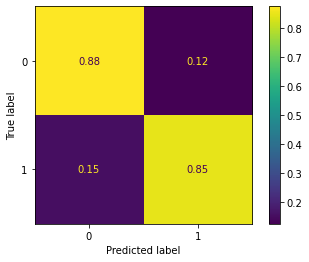

In [25]:
# plot the comfusion matrix
plot_confusion_matrix(sentiment_classifier, X_valid, y_valid, normalize='true')

In [26]:
# check the classification report
print(classification_report(y_valid, y_preds))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86      1875
           1       0.87      0.85      0.86      1875

    accuracy                           0.86      3750
   macro avg       0.86      0.86      0.86      3750
weighted avg       0.86      0.86      0.86      3750



In [27]:
#save model 
import joblib 

joblib.dump(sentiment_classifier, '../models/sentiment_ml_pipeline.pkl')

['../models/sentiment_ml_pipeline.pkl']